In [62]:
from bcb import sgs
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
def get_macro_data(start_date, end_date):
    series_codes = {
        'taxa_cambio': 10813, 
        'selic': 432,
        'ipca': 433,
        'pib': 4380
    }
    
    taxa_cambio = sgs.get({'taxa_cambio': series_codes['taxa_cambio']}, start=start_date, end=end_date)
    selic = sgs.get({'selic': series_codes['selic']}, start=start_date, end=end_date)
    ipca = sgs.get({'ipca': series_codes['ipca']}, start=start_date, end=end_date)
    pib = sgs.get({'pib': series_codes['pib']}, start=start_date, end=end_date)
    
    taxa_cambio.rename(columns={'taxa_cambio': 'Taxa_Cambio'}, inplace=True)
    selic.rename(columns={'selic': 'SELIC'}, inplace=True)
    ipca.rename(columns={'ipca': 'IPCA'}, inplace=True)
    pib.rename(columns={'pib': 'PIB'}, inplace=True)
    
    combined_data = taxa_cambio.join([selic, ipca, pib], how='outer')
    
    combined_data.ffill(inplace=True)
    
    combined_data.bfill(inplace=True)
    
    combined_data.interpolate(method='linear', inplace=True)
    
    return combined_data

In [64]:
def criar_matriz_correlacao_diaria(ticker, dados, macro_data):
    precos_diarios = dados['Adj Close']
    
    macro_diarios = macro_data.reindex(precos_diarios.index, method='ffill')
    
    dados_combinados = pd.DataFrame({
        'Preço': precos_diarios,
        'Taxa_Cambio': macro_diarios['Taxa_Cambio'],
        'SELIC': macro_diarios['SELIC'],
        'IPCA': macro_diarios['IPCA'],
        'PIB': macro_diarios['PIB']
    })
    
    dados_combinados['Preço'] = dados_combinados['Preço'].shift(-1)
    
    dados_combinados.dropna(inplace=True)
    
    matriz_correlacao = dados_combinados.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(matriz_correlacao, 
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=-1, 
                vmax=1,
                center=0)
    plt.title(f'Matriz de Correlação: Preço (dia seguinte) vs Indicadores Macroeconômicos ({ticker})')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return dados_combinados, matriz_correlacao

[*********************100%%**********************]  1 of 1 completed


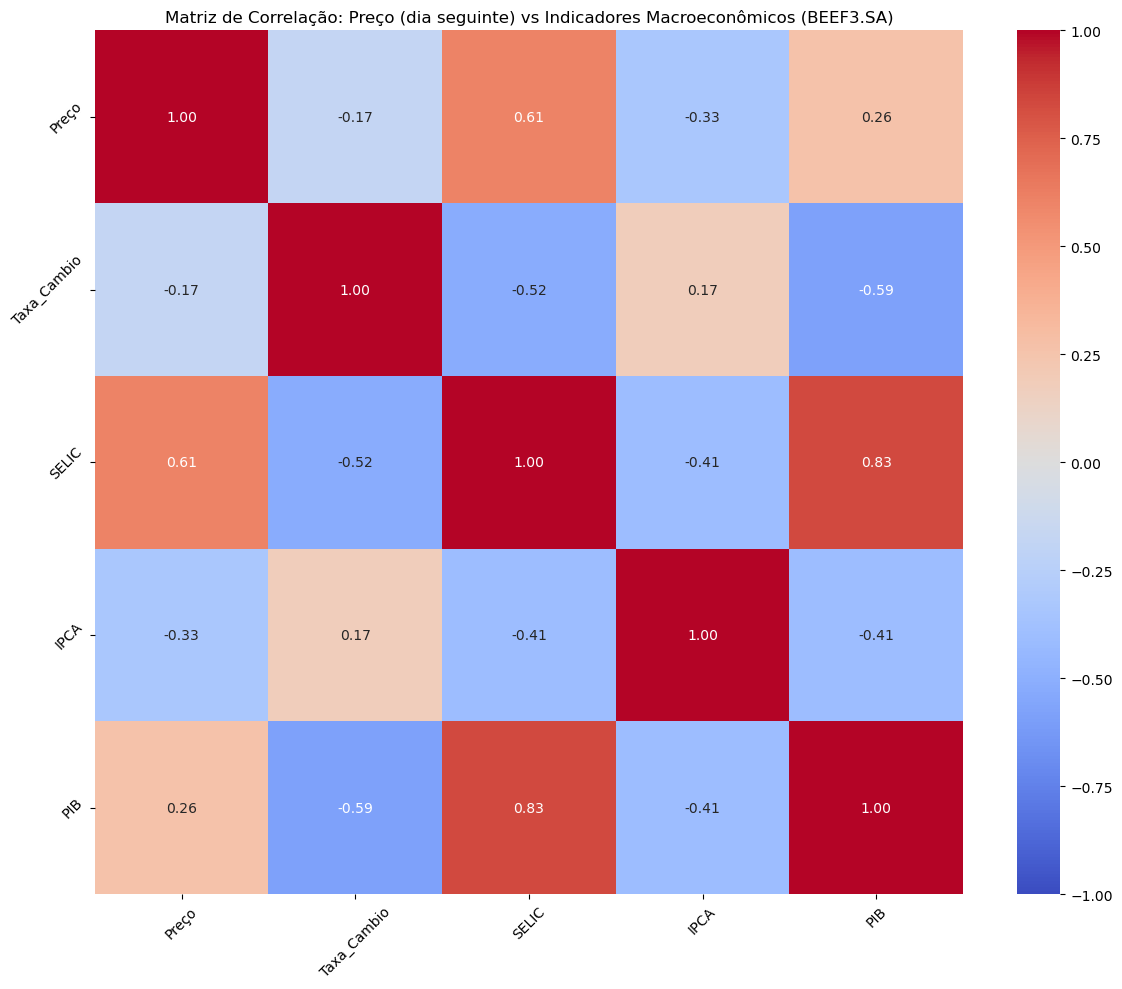


Matriz de Correlação:
                Preço  Taxa_Cambio     SELIC      IPCA       PIB
Preço        1.000000    -0.172082  0.607569 -0.333091  0.260110
Taxa_Cambio -0.172082     1.000000 -0.523219  0.173052 -0.585079
SELIC        0.607569    -0.523219  1.000000 -0.407286  0.829478
IPCA        -0.333091     0.173052 -0.407286  1.000000 -0.406955
PIB          0.260110    -0.585079  0.829478 -0.406955  1.000000


In [65]:
ticker = 'BEEF3.SA'  
start_date = '2021-01-01'
end_date = '2023-12-31'

dados = yf.download(ticker, start=start_date, end=end_date)

macro_data = get_macro_data(start_date, end_date)


dados_diarios, matriz_correlacao = criar_matriz_correlacao_diaria(ticker, dados, macro_data)
print("\nMatriz de Correlação:")
print(matriz_correlacao)